In [344]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, Conv2D, Conv2DTranspose, Lambda, BatchNormalization
#from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import numpy as np
import msprime
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap

# <center> Variational Autoencoder </center>

In [345]:
# To sort the genotype matrices

from sklearn.neighbors import NearestNeighbors
def sort_min_diff(amat):
    '''this function takes in a SNP matrix with indv on rows and returns the same 
    matrix with indvs sorted by genetic similarity.this problem is NP, so here we 
    use a nearest neighbors approx.  it's not perfect, but it's fast and generally performs ok.
    assumes your input matrix is a numpy array'''
    mb = NearestNeighbors(len(amat), metric='manhattan').fit(amat)
    v = mb.kneighbors(amat)
    smallest = np.argmin(v[0].sum(axis=1))
    return amat[v[1][smallest]]

In [346]:
# Simulates the genotype matrices

def simulations(range_=10000, img_dim=64):
    
    gene_list = []
    resized_img = []
    rr_min, rr_max = 1e-7, 1e-9
    rr = np.random.uniform(rr_min, rr_max, size=range_)
    
    for i in range(range_):
        i = msprime.simulate(sample_size=100, Ne=10000, length=1e5, mutation_rate=1e-8, recombination_rate=rr[i])
        gene_list.append(np.array(i.genotype_matrix(), dtype=float))
    
    for i in gene_list:
        resized_img.append(resize(sort_min_diff(sort_min_diff(i.T).T).T, (img_dim, img_dim), preserve_range=True))
    
    return np.asarray(resized_img), rr, rr_min, rr_max

In [347]:
# Call's the simulation function

img_data, rr, rr_min, rr_max = simulations(range_=100000, img_dim=32)

In [348]:
# To split the data into train, test and validation data

def data_split(data, rec_rate):
    
    x_train = data[:int(len(data) * 0.7)]
    x_test = data[int(len(data) * 0.7):int(len(data) * 0.85)]
    x_val = data[int(len(data) * 0.85):]
    
    # Corresponding to x_test data
    rr_test = rec_rate[int(len(rec_rate) * 0.7):int(len(rec_rate) * 0.85)]
    
    return x_train, x_test, x_val, rr_test

In [349]:
# Call's the data_split function

x_train, x_test, x_val, rr_test = data_split(img_data, rr)

In [350]:
# Flattening of the images

x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_val = x_val.reshape(len(x_val), np.prod(x_val.shape[1:]))

In [351]:
# Parameters

img_size = 32
original_dim = img_size * img_size
latent_dim = 300

In [352]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(latent_dim,))
    return z_mean + K.exp(z_log_std) * epsilon

In [353]:
def vae_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.square(x - x_decoded_mean), axis=-1), axis=-1)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss

In [354]:
# Encoder

x = Input(shape=(original_dim,))
h = Dense(3 * latent_dim, activation='relu')(x)
h = Dense(2 * latent_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

# Sampling

z = Lambda(sampling)([z_mean, z_log_std])

# Decoder

decoder_h1 = Dense(2 * latent_dim, activation='relu')
decoder_h2 = Dense(3 * latent_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h1_decoded = decoder_h1(z)
h2_decoded = decoder_h2(h1_decoded)
x_decoded_mean = decoder_mean(h2_decoded)

In [355]:
# Instansiate models

vae = Model(x, x_decoded_mean)

encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h1(decoder_input)
_h1_decoded = decoder_h2(_h_decoded)
_x_decoded_mean = decoder_mean(_h1_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [356]:
# Compile the vae

vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False, metrics=['accuracy'])

In [357]:
# Train the network

his = vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=100,
        batch_size=128,
        validation_data=(x_val, x_val))

Train on 70000 samples, validate on 15000 samples
Epoch 1/100
70000/70000 [==============================] - 82s 1ms/sample - loss: 10.1910 - accuracy: 0.2893 - val_loss: 8.4791 - val_accuracy: 0.3579
Epoch 2/100
70000/70000 [==============================] - 79s 1ms/sample - loss: 7.7877 - accuracy: 0.3414 - val_loss: 7.5849 - val_accuracy: 0.3567
Epoch 3/100
70000/70000 [==============================] - 77s 1ms/sample - loss: 7.1096 - accuracy: 0.3408 - val_loss: 7.1108 - val_accuracy: 0.3516
Epoch 4/100
70000/70000 [==============================] - 83s 1ms/sample - loss: 6.6630 - accuracy: 0.3433 - val_loss: 6.7123 - val_accuracy: 0.3573
Epoch 5/100
70000/70000 [==============================] - 80s 1ms/sample - loss: 6.5427 - accuracy: 0.3481 - val_loss: 6.3872 - val_accuracy: 0.3535
Epoch 6/100
70000/70000 [==============================] - 77s 1ms/sample - loss: 6.3181 - accuracy: 0.3471 - val_loss: 6.2537 - val_accuracy: 0.3541
Epoch 7/100
70000/70000 [========================

70000/70000 [==============================] - 78s 1ms/sample - loss: 5.0177 - accuracy: 0.3511 - val_loss: 5.1192 - val_accuracy: 0.3575
Epoch 55/100
70000/70000 [==============================] - 77s 1ms/sample - loss: 5.0197 - accuracy: 0.3509 - val_loss: 5.1305 - val_accuracy: 0.3577
Epoch 56/100
70000/70000 [==============================] - 81s 1ms/sample - loss: 5.0009 - accuracy: 0.3509 - val_loss: 5.1196 - val_accuracy: 0.3580
Epoch 57/100
70000/70000 [==============================] - 78s 1ms/sample - loss: 4.9915 - accuracy: 0.3509 - val_loss: 5.1052 - val_accuracy: 0.3568
Epoch 58/100
70000/70000 [==============================] - 80s 1ms/sample - loss: 4.9900 - accuracy: 0.3510 - val_loss: 5.1408 - val_accuracy: 0.3564
Epoch 59/100
70000/70000 [==============================] - 78s 1ms/sample - loss: 4.9886 - accuracy: 0.3509 - val_loss: 5.1450 - val_accuracy: 0.3571
Epoch 60/100
70000/70000 [==============================] - 77s 1ms/sample - loss: 4.9871 - accuracy: 0.350

In [358]:
def plot_loss(loss, val_loss, accuracy, val_accuracy):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    plt.subplot(122)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

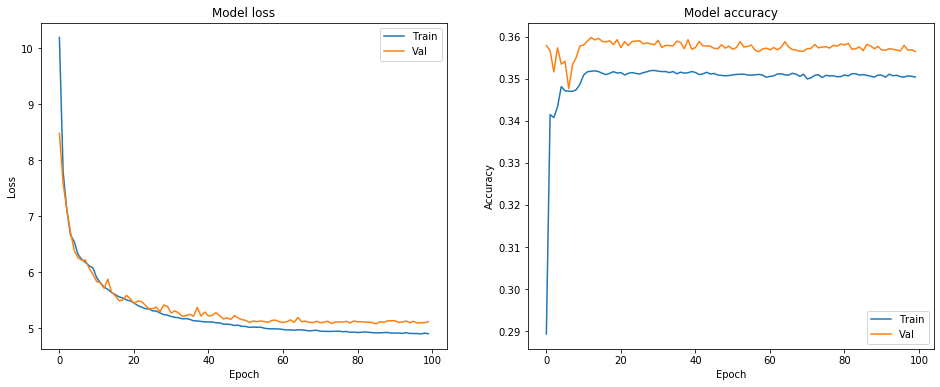

In [359]:
plot_loss(his.history['loss'], his.history['val_loss'], his.history['accuracy'], his.history['val_accuracy'])

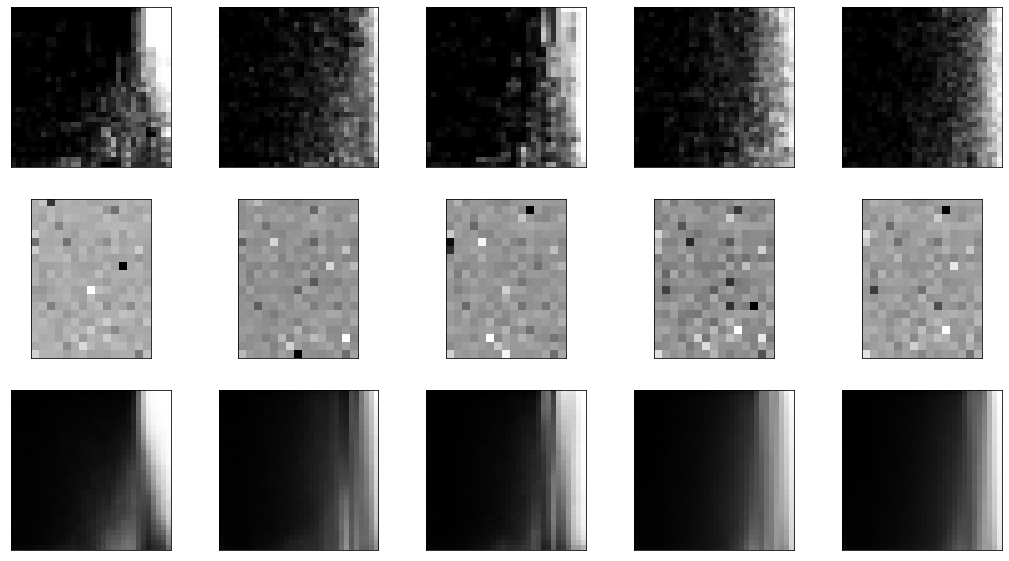

In [360]:
num_images = 5
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test)

plt.figure(figsize=(18, 10))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(20, 15))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [361]:
# Dimensionallity reduction using tSNE

tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(encoded_imgs)

In [362]:
# Dimensionallity reduction using UMAP

reducer = umap.UMAP()
umap_ = reducer.fit_transform(encoded_imgs)

/Users/raninielsen/anaconda3/envs/tensorflow_sess/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/tensorflow_sess/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/raninielsen/anaconda3/envs/tensorflow_sess/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for 

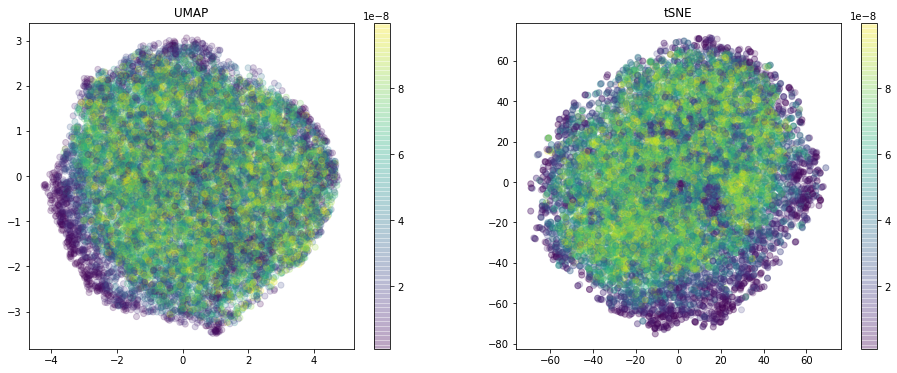

In [363]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.scatter(umap_[:,0], umap_[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('UMAP')
plt.colorbar()

plt.subplot(122)
plt.scatter(x_tsne[:,0], x_tsne[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('tSNE')
plt.colorbar()
plt.show()

In [364]:
# Finds the idx of the lowest and highest recombination rate values

low = np.argmin(rr)
high = np.argmax(rr)

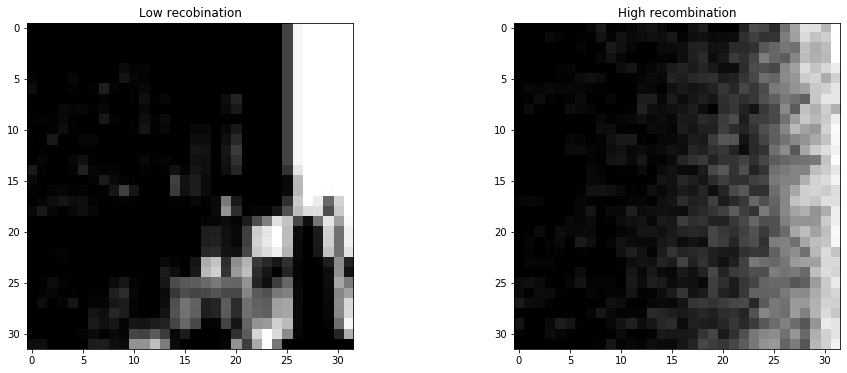

In [365]:
# Visualization of the lowest vs highest recombination rates

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Low recobination')
plt.imshow(img_data[low])

plt.subplot(122)
plt.title('High recombination')
plt.imshow(img_data[high])
plt.show()

In [366]:
low_test = np.argmin(rr_test)

In [367]:
high_test = np.argmax(rr_test)

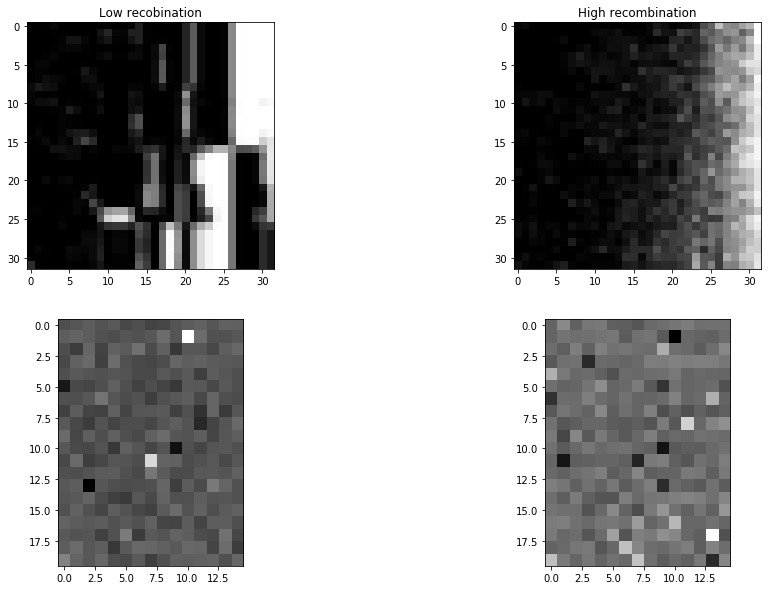

In [368]:
# Visualization of the lowest and highest recombination rate of the test data and their encoding layers

plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.title('Low recobination')
plt.imshow(x_test[low_test].reshape(32, 32))

plt.subplot(222)
plt.title('High recombination')
plt.imshow(x_test[high_test].reshape(32, 32))

plt.subplot(223)
#plt.title('Low recobination')
plt.imshow(encoded_imgs[low_test].reshape(20, 15))

plt.subplot(224)
#plt.title('High recombination')
plt.imshow(encoded_imgs[high_test].reshape(20, 15))
plt.show()

In [369]:
# Sorts the recombination rate vector from lowest to highest, by idx's

idx_sorted = np.argsort(rr_test)

In [370]:
# Obtaining top 5% of the lowest and highest recombination rates

top_low = idx_sorted[:int(len(idx_sorted) * 0.05)]
top_high = idx_sorted[-int(len(idx_sorted) * 0.05):]

In [371]:
# Averaging the top 5% lowest and highest recmobination rate vectors
# and generates 32x32 images from them

low_rec_vec = np.mean(encoded_imgs[top_low], axis=0)
low_rec_vec_img = generator.predict(low_rec_vec.reshape(1, 300))
high_rec_vec = np.mean(encoded_imgs[top_high], axis=0)
high_rec_vec_img = generator.predict(high_rec_vec.reshape(1, 300))

In [372]:
# Creating vectors to represent recombination rate changes, and generating their images

high_minus_low = high_rec_vec - low_rec_vec 
low_minus_high = low_rec_vec - high_rec_vec
high_minus_low_img = generator.predict(high_minus_low.reshape(1, 300))
low_minus_high_img = generator.predict(low_minus_high.reshape(1, 300))

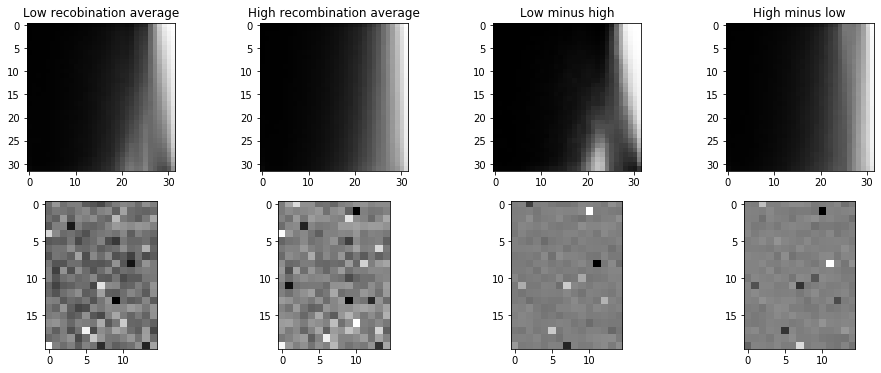

In [373]:
# Visualization of the vectors and their trnsformations

plt.figure(figsize=(16, 6))
plt.subplot(241)
plt.title('Low recobination average')
plt.imshow(low_rec_vec_img.reshape(32, 32))

plt.subplot(242)
plt.title('High recombination average')
plt.imshow(high_rec_vec_img.reshape(32, 32))

plt.subplot(243)
plt.title('Low minus high')
plt.imshow(low_minus_high_img.reshape(32, 32))

plt.subplot(244)
plt.title('High minus low')
plt.imshow(high_minus_low_img.reshape(32, 32))

plt.subplot(245)
#plt.title('High recombination')
plt.imshow(low_rec_vec.reshape(20, 15))

plt.subplot(246)
#plt.title('Mix')
plt.imshow(high_rec_vec.reshape(20, 15))

plt.subplot(247)
#plt.title('Mix')
plt.imshow(low_minus_high.reshape(20, 15))

plt.subplot(248)
#plt.title('Mix')
plt.imshow(high_minus_low.reshape(20, 15))
plt.show()

In [374]:
orig = x_test[:3]
enc_hml = encoded_imgs[:3] + high_minus_low
enc_lmh = encoded_imgs[:3] + low_minus_high
gen_hml = generator.predict(enc_hml)
gen_lmh = generator.predict(enc_lmh)

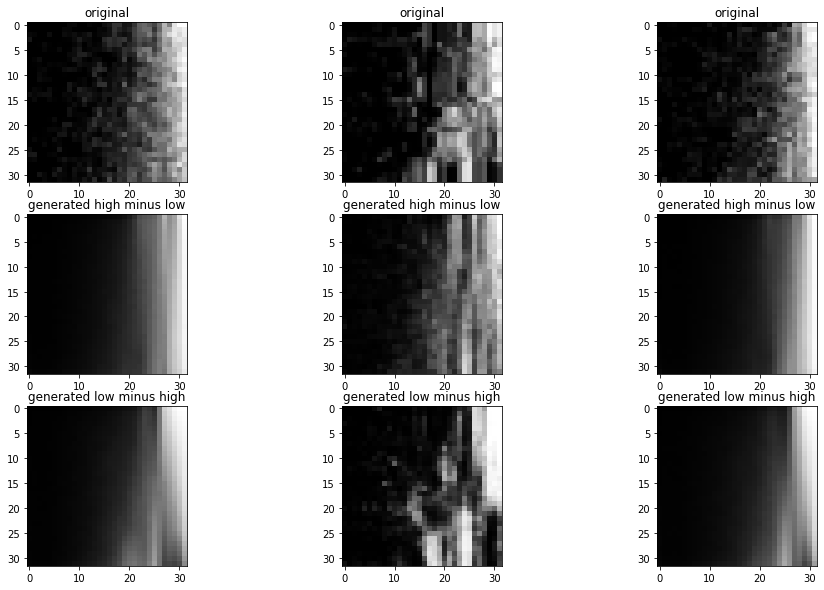

In [375]:
plt.figure(figsize=(16, 10))
plt.subplot(331)
plt.title('original')
plt.imshow(orig[0].reshape(32, 32))

plt.subplot(332)
plt.title('original')
plt.imshow(orig[1].reshape(32, 32))

plt.subplot(333)
plt.title('original')
plt.imshow(orig[2].reshape(32, 32))

plt.subplot(334)
plt.title('generated high minus low')
plt.imshow(gen_hml[0].reshape(32, 32))

plt.subplot(335)
plt.title('generated high minus low')
plt.imshow(gen_hml[1].reshape(32, 32))

plt.subplot(336)
plt.title('generated high minus low')
plt.imshow(gen_hml[2].reshape(32, 32))

plt.subplot(337)
plt.title('generated low minus high')
plt.imshow(gen_lmh[0].reshape(32, 32))

plt.subplot(338)
plt.title('generated low minus high')
plt.imshow(gen_lmh[1].reshape(32, 32))

plt.subplot(339)
plt.title('generated low minus high')
plt.imshow(gen_lmh[2].reshape(32, 32))
plt.show()